# To TG


# INIT


In [2]:
import numpy as np
from pprint import pprint
from copy import deepcopy
import sys
from pathlib import Path


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup
from laboneq.simple import *
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.calibration import Oscillator, SignalCalibration
from laboneq.dsl.enums import ModulationType




# descriptor = generate_descriptor(
#     #pqsc=[""], # 장비 여러개 사용시
#     shfqc_6=["DEV12256"], 
#     number_data_qubits=3,
#     multiplex=True,
#     number_multiplex=6,
#     include_cr_lines=False,
#     include_ef_lines=True,
#     get_zsync=False,  # Only set to True when using real device
#     save = True,
#     filename="1port",
#     ip_address="192.168.0.83"
# )


#descriptor
#setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
descriptor_candidates = [
    Path("examples/selectiveRIP/Descriptors/1port.yaml"),
    Path("Descriptors/1port.yaml"),
]
descriptor_path = next((p for p in descriptor_candidates if p.exists()), descriptor_candidates[0])
setup = DeviceSetup.from_yaml(filepath=str(descriptor_path.resolve()), server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments


bus_ids = [f"b{i}" for i in range(3)]
bus_port = [3,4,5] #used 1,2,3 for qubit drive

for i, bus in zip(bus_port,bus_ids):
    setup.add_connections(
        setup.instruments[0].uid,
        # each bus uses its own drive:
        create_connection(
            to_signal=f"{bus}/drive",
            ports=f"SGCHANNELS/{i}/OUTPUT"
        ))

# Calibrate qubit drive/measure lines for oscillator phase increments
qubit_ids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
for qubit in qubit_ids:
    for line, frequency, mod_type in [
        ("drive", 5e9, ModulationType.HARDWARE),
        ("drive_ef", 6e9, ModulationType.HARDWARE),
        ("measure", 4e9, ModulationType.SOFTWARE),
    ]:
        logical_signal = setup.logical_signal_by_uid(f"{qubit}/{line}")
        oscillator = Oscillator(modulation_type=mod_type)
        logical_signal.calibration = SignalCalibration(
            local_oscillator=Oscillator(frequency=frequency),
            oscillator=oscillator,
        )
        if line == "measure":
            acquire_signal = setup.logical_signal_by_uid(f"{qubit}/acquire")
            acquire_signal.calibration = SignalCalibration(
                local_oscillator=Oscillator(frequency=frequency),
                oscillator=oscillator,
            )

project_root = next(
    (p for p in [Path.cwd(), *Path.cwd().parents] if (p / "qpu_types").exists() and (p / "helper.py").exists()),
    Path.cwd(),
)
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from qpu_types.fixed_transmon import FixedTransmonQubit, FixedTransmonQubitParameters
from qpu_types.bus_cavity import BusCavity, BusCavityParameters
from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from helper import load_qubit_parameters, save_qubit_parameters

qubit_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
bus_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("b")]

qubits = FixedTransmonQubit.from_device_setup(
    setup, qubit_uids=qubit_uids)
buses = BusCavity.from_device_setup(
    setup, qubit_uids=bus_uids)

qpu = QPU(quantum_elements={"qubits" : qubits, "bus" : buses}, quantum_operations=[FixedTransmonOperations, BusCavityOperations])


# from laboneq.simple import workflow
# folder_store = workflow.logbook.FolderStore("./experiment_store") 
# folder_store.activate()
# #folder_store.deactivate()
# #workflow.logbook.LoggingStore().activate()
# #workflow.logbook.LogbookStore().deactivate()

import os
from datetime import datetime
def find_latest_json(folder_path):
    files = [f for f in os.listdir(folder_path)]
    timestamps = []
    for file in files:
        try:
            # Extract a timestamp assuming it's included in the filename
            timestamp_str = file.split('_', 1)[0]  # Assuming YYYYMMDDHHMMSS format
            timestamp = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')
            timestamps.append((timestamp, file))
        except ValueError:
            print("fuck")
            continue  # Skip files that do not match the timestamp format

       # Find the most recent file
    if timestamps:
        latest_file = max(timestamps, key=lambda x: x[0])[1]
        return os.path.join(folder_path, latest_file)
    return None

qb_pars_file = find_latest_json("./qpu_parameters/")
print(f"LOADED: {qb_pars_file}")

from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
import laboneq.dsl.quantum.qpu as qpu_mod

class CombinedOperations(FixedTransmonOperations, BusCavityOperations):
    pass

qpu_mod.CombinedOperations = CombinedOperations

qpu = load(qb_pars_file)

buses = qpu.groups.bus
qubits = qpu.groups.qubits


from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store")
folder_store.activate()

fuck
LOADED: ./qpu_parameters/20260224-0850_rip_tomo


In [3]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=False, do_emulation=False)
#session.disconnect()


[2026.02.24 10:04:00.159] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/Research/code/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.02.24 10:04:00.163] INFO    VERSION: laboneq 25.10.3
[2026.02.24 10:04:00.164] INFO    Connecting to data server at 192.168.0.83:8004
[2026.02.24 10:04:00.244] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.02.24 10:04:00.380] INFO    Configuring the device setup
[2026.02.24 10:04:00.411] INFO    The device setup is configured


# Multiplexed IQ Clouds


[2026.02.24 10:04:02.547] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.24 10:04:02.548] INFO      Workflow 'iq_cloud': execution started at 2026-02-24 01:04:02.546947Z         
[2026.02.24 10:04:02.548] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.24 10:04:02.561] INFO    Task 'temporary_qpu': started at 2026-02-24 01:04:02.560793Z
[2026.02.24 10:04:02.562] INFO    Task 'temporary_qpu': ended at 2026-02-24 01:04:02.561866Z
[2026.02.24 10:04:02.565] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-24 
[2026.02.24 10:04:02.565] INFO    01:04:02.564375Z
[2026.02.24 10:04:02.566] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-24 01:04:02.566026Z
[2026.02.24 10:04:02.568] INFO    Task 'create_experiment': started at 2026-02-24 01:04:02.568141Z
[2026.02.24 10:04:02.574] INFO    Task 'create_experiment': ended at 2026-02-24 01:04:02.574264Z
[202

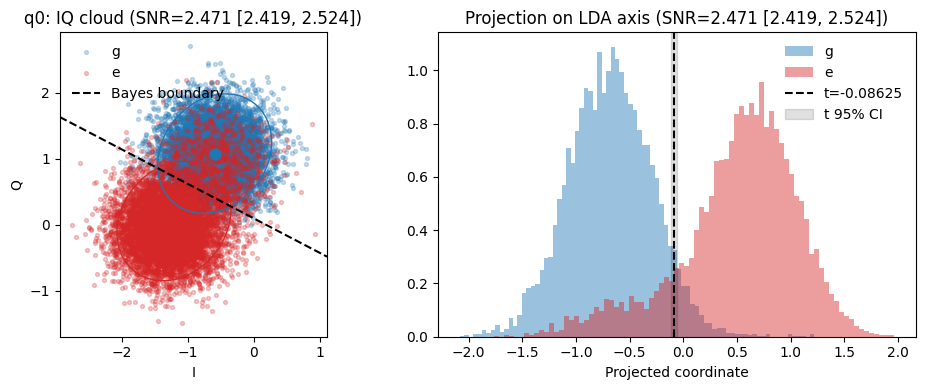

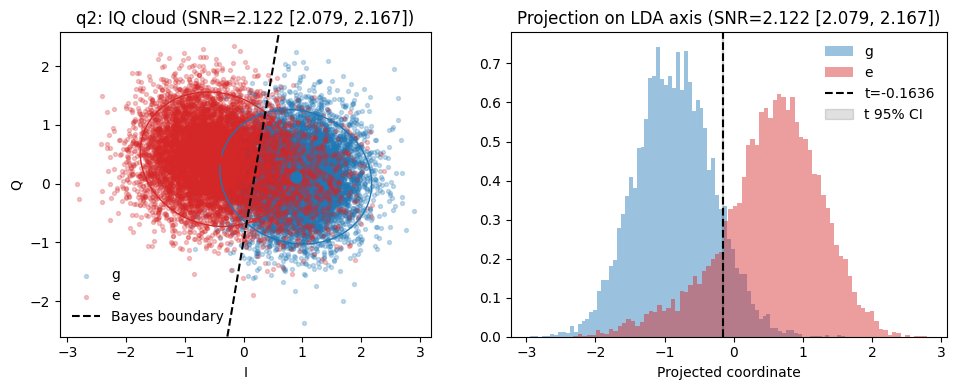

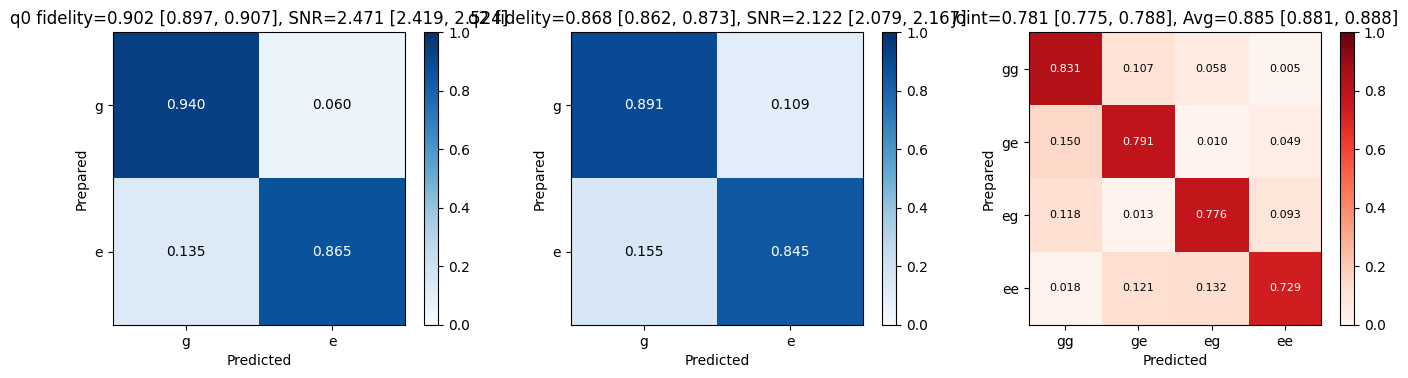

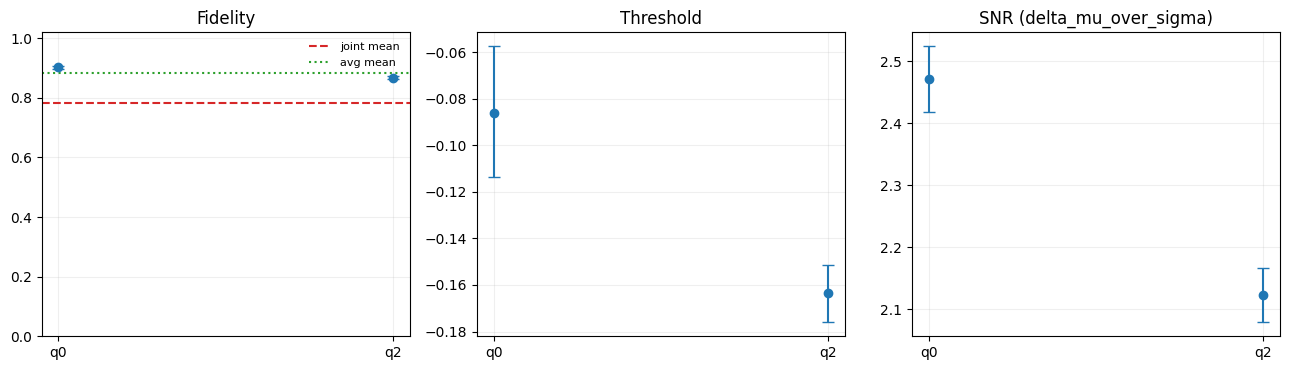

In [4]:
from experiments import iq_cloud_common, iq_cloud
from experiments import iq_cloud_common, iq_cloud
q = qubits[0]
qq = qubits[2]

temporary_parameters = {}
q_temp_pars = deepcopy(q.parameters)
qq_temp_pars = deepcopy(qq.parameters)

# q_temp_pars.readout_integration_delay = 180e-9
# qq_temp_pars.readout_integration_delay= 180e-9
# q_temp_pars.readout_length = 1.6e-6
# qq_temp_pars.readout_length = 1.6e-6
temporary_parameters[q.uid] = q_temp_pars
temporary_parameters[qq.uid] = qq_temp_pars
#######################################################################

options = iq_cloud.experiment_workflow.options()
options.do_analysis(True)
options.update(False)
#options.count(1024)

iq_result = iq_cloud.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=[q,qq],
    temporary_parameters=temporary_parameters,
    options=options,
).run()




# Bus setting


# ToTG: 2Q Quantum State Tomography + Custom Bus Drive 실행 예제

이 노트북은 `experiments/two_qubit_state_tomography.py` 실험 모듈을 사용해서 아래를 한 번에 보여줍니다.

1. 2Q tomography 워크플로 실행
2. bus별 RIP drive 파라미터(custom bus drive) 주입
3. 결과에서 density matrix(`rho_hat`) 추출 및 파일 저장

대상 독자: 이미 `session`, `qpu`, `qubits`, `buses`를 준비해 둔 실험 사용자


## 실험 모듈 사용법 (핵심)

### 1) 엔트리 포인트
- `two_qubit_state_tomography.experiment_workflow(...)`

필수 인자:
- `session`: LabOne Q 세션
- `qpu`: `QPU` 객체
- `ctrl`, `targ`: tomography 대상 2개 qubit
- `bus`: 단일 bus 또는 bus 리스트

주요 선택 인자:
- `readout_calibration_result`: readout calibration 결과 (없으면 옵션에 따라 내부에서 생성)
- `target_state`: fidelity 계산 target (`"++"`, `"00"`, `"+-"`, `"bell_phi_plus"`, ...)
- `temporary_parameters`: 임시 파라미터 오버라이드
- `options`: workflow 옵션 객체

### 2) 옵션 객체
- `opts = two_qubit_state_tomography.experiment_workflow.options()`
- 자주 쓰는 옵션
  - `opts.do_analysis(True/False)`
  - `opts.do_readout_calibration(True/False)`
  - `opts.validation_mode(True/False)`
  - `opts.use_rip(True/False)`
  - `opts.initial_state("++", "+-", "--", "00", ... )`
  - `opts.enforce_target_match(True/False)`
  - `opts.count(shots)`

주의:
- `validation_mode=True`면 `use_rip`는 자동으로 비활성화됩니다.
- 분석(`do_analysis=True`) 시 INTEGRATION 기반 readout calibration 입력이 필요합니다.

### 3) custom bus drive가 적용되는 방식
`create_experiment` 내부에서 bus별로 아래 파라미터를 읽어 RIP pulse를 구성합니다.
- 주파수: `resonance_frequency_bus + rip_detuning`
- 위상: `rip_phase` (없으면 기본 `pi/2`)
- 파형 파라미터: `rip_amplitude`, `rip_length`, `rip_pulse`

즉, 실행 전에 각 `bus.parameters.*`를 설정하면 해당 값으로 RIP drive가 나갑니다.


In [ ]:
# Imports + project path setup
from __future__ import annotations

import sys
from pathlib import Path
from pprint import pprint

import numpy as np

project_root = next(
    (
        p
        for p in [Path.cwd(), *Path.cwd().parents]
        if (p / "experiments").exists() and (p / "qpu_types").exists()
    ),
    Path.cwd(),
)
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from experiments import two_qubit_readout_calibration
from experiments import two_qubit_state_tomography

print("project_root:", project_root)


## 실행 전 환경 객체 확인

이 셀은 아래 전역 변수가 이미 준비되어 있다는 가정으로 동작합니다.
- `session`
- `qpu`
- `qubits`
- `buses`

보통 `2Q_QST_TEST_NEW.ipynb`의 INIT/장비연결 셀을 먼저 실행한 뒤 이 노트북을 사용합니다.


In [ ]:
required = ["session", "qpu", "qubits", "buses"]
missing = [name for name in required if name not in globals()]
if missing:
    raise RuntimeError(
        "Missing required globals: "
        + ", ".join(missing)
        + ". Run your setup/connection notebook first."
    )

# Example target qubits/buses (필요시 인덱스 변경)
ctrl = qubits[0]
targ = qubits[2]
custom_buses = [buses[0], buses[1], buses[2]]

if "temporary_parameters" not in globals():
    temporary_parameters = {}

print("ctrl:", ctrl.uid)
print("targ:", targ.uid)
print("bus list:", [b.uid for b in custom_buses])


## custom bus drive 파라미터 설정

아래 예제는 각 bus에 RIP 관련 파라미터를 직접 주입합니다.

필드 의미:
- `resonance_frequency_bus`: bus 공진 주파수
- `rip_detuning`: RIP detuning
- `rip_amplitude`: RIP pulse amplitude
- `rip_length`: RIP pulse length
- `rip_phase`: RIP phase

실험 모듈은 이 값들을 읽어 bus drive를 구성합니다.


In [ ]:
# bus uid별 custom parameter (예시값)
custom_bus_params = {
    custom_buses[0].uid: {
        "resonance_frequency_bus": 5.5055e9,
        "rip_detuning": -11e6,
        "rip_amplitude": 0.09,
        "rip_length": 480e-9,
        "rip_phase": float(np.pi / 2),
    },
    custom_buses[1].uid: {
        "resonance_frequency_bus": 6.4214e9,
        "rip_detuning": -20e6,
        "rip_amplitude": 0.20,
        "rip_length": 480e-9,
        "rip_phase": float(np.pi / 2),
    },
    custom_buses[2].uid: {
        "resonance_frequency_bus": 5.9807e9,
        "rip_detuning": 7e6,
        "rip_amplitude": 0.20,
        "rip_length": 480e-9,
        "rip_phase": float(np.pi / 2),
    },
}

for b in custom_buses:
    params = custom_bus_params[b.uid]
    for key, val in params.items():
        setattr(b.parameters, key, val)

summary = {
    b.uid: {
        "resonance_frequency_bus": b.parameters.resonance_frequency_bus,
        "rip_detuning": b.parameters.rip_detuning,
        "rip_amplitude": b.parameters.rip_amplitude,
        "rip_length": b.parameters.rip_length,
        "rip_phase": b.parameters.rip_phase,
    }
    for b in custom_buses
}
pprint(summary)


## QST 실행 (RIP on + 외부 readout calibration 사용)

권장 패턴:
1. readout calibration을 먼저 1회 수행
2. 결과를 `readout_calibration_result`로 tomography workflow에 전달
3. tomography 옵션에서 `do_readout_calibration(False)`로 고정

이 패턴을 쓰면 shot sweep/반복 실험에서 calibration 누락 문제를 줄일 수 있습니다.


In [ ]:
# 1) Readout calibration (없으면 1회 생성)
if "readout_cal_result_new" not in globals() or readout_cal_result_new is None:
    readout_cal_result_new = two_qubit_readout_calibration.experiment_workflow(
        session=session,
        qpu=qpu,
        ctrl=ctrl,
        targ=targ,
        temporary_parameters=temporary_parameters,
    ).run()

# 2) Tomography options
opts = two_qubit_state_tomography.experiment_workflow.options()
opts.do_analysis(True)
opts.do_readout_calibration(False)
opts.validation_mode(False)
opts.use_rip(True)
opts.initial_state("++")
opts.enforce_target_match(True)
opts.count(2048)

# 3) Tomography run (custom bus list 전달)
twoq_qst_result = two_qubit_state_tomography.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=ctrl,
    targ=targ,
    bus=custom_buses,
    readout_calibration_result=readout_cal_result_new,
    target_state="++",
    options=opts,
    temporary_parameters=temporary_parameters,
).run()

print("QST workflow finished.")


## 결과에서 density matrix 추출 + 저장

반환 구조에서 `analysis_result`를 우선 찾고, wrapper(`.output`)를 반복 언랩해서 안전하게 읽습니다.

최종 추출 항목:
- `rho_hat_real` (4x4 실수부)
- `rho_hat_imag` (4x4 허수부)
- `metrics` (fidelity/purity/min eigenvalue 등)


In [ ]:
def unwrap_output(obj):
    cur = obj
    for _ in range(24):
        if hasattr(cur, "output"):
            cur = cur.output
            continue
        return cur
    return cur


def extract_analysis_output(workflow_result):
    out = unwrap_output(getattr(workflow_result, "output", workflow_result))

    if isinstance(out, dict):
        nested = out.get("analysis_result")
        if isinstance(nested, dict):
            return nested
        if isinstance(out, dict) and "rho_hat_real" in out and "rho_hat_imag" in out:
            return out

    # Fallback: task tree search
    stack = [workflow_result]
    seen = set()
    while stack:
        node = stack.pop()
        if node is None:
            continue
        nid = id(node)
        if nid in seen:
            continue
        seen.add(nid)

        tasks = getattr(node, "tasks", None)
        if tasks is not None:
            try:
                task_list = list(tasks)
            except Exception:
                task_list = []
            names = {getattr(t, "name", "") for t in task_list}
            if (
                "maximum_likelihood_reconstruct" in names
                and "extract_assignment_matrix" in names
            ):
                out2 = unwrap_output(getattr(node, "output", None))
                if isinstance(out2, dict):
                    return out2

            for t in task_list:
                stack.append(t)
                stack.append(getattr(t, "output", None))

        stack.append(getattr(node, "output", None))

    raise RuntimeError("Could not materialize analysis output.")


analysis = extract_analysis_output(twoq_qst_result)
rho_real = np.asarray(analysis["rho_hat_real"], dtype=float)
rho_imag = np.asarray(analysis["rho_hat_imag"], dtype=float)
rho_hat = rho_real + 1j * rho_imag

# numerical cleanup
rho_hat = (rho_hat + rho_hat.conj().T) / 2.0
rho_hat /= np.trace(rho_hat)

print("rho_hat shape:", rho_hat.shape)
print("trace(rho_hat):", np.trace(rho_hat))
print("metrics:")
pprint(analysis.get("metrics", {}))

# Save density matrix
save_dir = project_root / "examples" / "selectiveRIP" / "output"
save_dir.mkdir(parents=True, exist_ok=True)
out_npz = save_dir / "twoq_qst_rho_hat.npz"
out_json = save_dir / "twoq_qst_metrics.json"

np.savez(out_npz, rho_hat_real=rho_real, rho_hat_imag=rho_imag, rho_hat=rho_hat)
out_json.write_text(__import__("json").dumps(analysis.get("metrics", {}), indent=2, ensure_ascii=False))

print("saved:", out_npz)
print("saved:", out_json)


## 자주 나는 에러와 점검 포인트

- `ValueError: readout_calibration_result is required...`
  - 원인: 분석에 필요한 readout calibration payload가 누락/언랩 실패
  - 조치: calibration을 1회 생성 후 `readout_calibration_result`로 명시 전달

- `NameError: unwrap_output is not defined`
  - 원인: 헬퍼 함수 셀 실행 순서 누락
  - 조치: helper 정의 셀을 먼저 실행하거나, 해당 셀 내부 fallback 정의 추가

- `In validation_mode, target_state must match initial_state`
  - 원인: `validation_mode=True` + `enforce_target_match=True`에서 target mismatch
  - 조치: `target_state`를 `initial_state`와 동일한 canonical label로 맞춤

- custom bus 적용이 의심될 때
  - `b.parameters.resonance_frequency_bus`, `rip_detuning`, `rip_amplitude`, `rip_length`, `rip_phase`를 실행 직전에 출력해서 확인
